In [1]:
#!pip install LightFM

### Import All Data

In [2]:
import pandas as pd
products=pd.read_csv("products.csv",index_col=None,header=0)
dept=pd.read_csv("departments.csv",index_col=None,header=0)
aisles=pd.read_csv("aisles.csv",index_col=None,header=0)
orders_product =pd.read_csv("order_products__prior.csv",index_col=None,header=0)
orders = pd.read_csv("orders.csv",index_col=None,header=0)

### Create a flat dataframe with 5k users


In [3]:
orders_s = orders[['order_id','user_id']].where(orders.user_id <= 20000).dropna()   #just use 5000 users
orders_s['user_id'] = orders_s['user_id'].astype(int)
orders_product_s = orders_product[['order_id','product_id']]
data=orders_product_s.merge(orders_s,on="order_id")
data=data.merge(products,on="product_id")
data=data.merge(aisles,on="aisle_id")
data=data.merge(dept,on="department_id")
data["product_desc"] = data["product_name"] + ", " + data["aisle"] + ", " + data["department"]
data = data.dropna()

In [4]:
data['user_id'].head(5)

0     3107
1    19074
2    13805
3    18865
4     1699
Name: user_id, dtype: int32

### dataframe with just required fields

In [5]:
data_small = data[['user_id','product_id','product_name', 'product_desc']].groupby(['user_id','product_id','product_name', 'product_desc']).size().reset_index(name="count")
data_small['purchased'] = 1

In [6]:
### create a product_id to product_name lookup
products_small = (data_small[['product_id','product_name']].drop_duplicates()).set_index('product_id')

### Split data into train and test

** Need to ensure both test and train have the same dimensions and user, product tupples

In [7]:
# from lightfm.cross_validation import random_train_test_split


# coo = coo_matrix((data_small['purchased'],(data_small['user_id'],data_small['product_id'])))  #full sparse matrix
# coo_train, coo_test = random_train_test_split(coo, test_percentage=0.2, random_state=None)  #train and test sets

In [8]:
from scipy.sparse import coo_matrix
import numpy as np
msk = np.random.rand(len(data_small)) < 0.8
traindf = data_small[msk]
testdf = data_small[~msk]

train = coo_matrix((data_small[msk]['purchased'],(data_small[msk]['user_id'],data_small[msk]['product_id'])))
test = coo_matrix((data_small[~msk]['purchased'],(data_small[~msk]['user_id'],data_small[~msk]['product_id'])))

In [12]:
#coo_train.shape, coo_test.shape, 
train.shape, test.shape

((20001, 49689), (20001, 49689))

## Model

 - Popularity model: Reccomend the k most popular products in the train set.

In [13]:
top10 = list(traindf.product_id.value_counts()[:10])

 - LightFm model: Use the bpr algoritm to reccomend products.

In [14]:
import os.path
import numpy as np
from lightfm import LightFM


model_warp = LightFM(loss='warp')
model_bpr = LightFM(loss='bpr')
model_logistic = LightFM(loss='logistic')

model_warp.fit(train, epochs=2, num_threads=4) 
model_bpr.fit(train, epochs=2, num_threads=4)
model_logistic.fit(train, epochs=2, num_threads=4)

C:\Anaconda\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


### Recommendations

In [21]:
def get_recommendations(model, coo_mtrx, users_id, k):
    n_items = coo_mtrx.shape[1]
    scores = model.predict(users_id, np.arange(n_items))
    top_scores = np.argsort(-scores)[:k]

    print ('Recomendations for user %s:' % users_id)

    for x in top_scores.tolist():
        print(products_small.loc[x].product_name)
        
get_recommendations(model_bpr, test, 1, 10)

Recomendations for user 1:
Banana
Bag of Organic Bananas
Organic Strawberries
Organic Baby Spinach
Large Lemon
Limes
Organic Hass Avocado
Organic Garlic
Organic Avocado
Organic Blueberries


In [22]:
get_recommendations(model_bpr, test, 10, 10)

Recomendations for user 10:
Banana
Organic Strawberries
Organic Baby Spinach
Limes
Bag of Organic Bananas
Large Lemon
Organic Garlic
Organic Avocado
Organic Hass Avocado
Organic Yellow Onion


## Evaluation

In [15]:
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.evaluation import reciprocal_rank

In [16]:
# Need to transform test set in order to evaluate all products on a per user basis.
processedtest = testdf.groupby('user_id')['product_id'].apply(list)

### Precision-Recall curve
 - Define methods to calculate precision and recall for reccomending the k most popular products in train set.

In [17]:
def precision(userlist,reco):
    """
    Measure the precision at k metric for a model: 
    
    Parameters
    ----------
    userlist: list of product ids per user in the test set.
    reco: list of k recommendations from the model.
    
    """
    hits = len(list(set(userlist) & set(reco)))
    return hits/len(reco)

In [18]:
def recall(userlist,reco):
    """
    Measure the recall at k metric a the model: 
    
    Parameters
    ----------
    userlist: list of product ids per user in the test set.
    reco: list of k recommendations from the model.
    
    """
    
    hits = len(list(set(userlist) & set(reco)))
    return hits/len(userlist)
    

 - Calculate Precision and Recall for reccomending the k most popular items in the training set.
Evaluated k between 1 to 15.

In [31]:
precision_scorefreq = []
recall_scorefreq =[]
for k in range(1,15):
    topk = list(traindf.product_id.value_counts()[:k])
    preci =[]
    recal = []
    for i,c in enumerate(processedtest) :
        preci.append(precision(c,topk ) )
        recal.append( recall(c,topk ) )
    precision_scorefreq.append(np.mean(preci) )
    recall_scorefreq.append(np.mean(recal) )

 - Calculate precision and recall @ k from the LightFm models. Evaluated k between 1 to 15.

In [32]:
precision_scores = []
recall_scores =[]
for x in range(1,15):
    precision_scores.append(precision_at_k(model_bpr, test, k=x, num_threads=4).mean())
    recall_scores.append(recall_at_k(model_bpr, test, k=x, num_threads=4).mean())
    #print(2)

In [33]:
precision_scores_warp = []
recall_scores_warp =[]
for x in range(1,15):
    precision_scores_warp.append(precision_at_k(model_warp, test, k=x, num_threads=4).mean())
    recall_scores_warp.append(recall_at_k(model_warp, test, k=x, num_threads=4).mean())
    #print(2)

In [34]:
precision_scores_logistic = []
recall_scores_logistic =[]
for x in range(1,15):
    precision_scores_logistic.append(precision_at_k(model_logistic, test, k=x, num_threads=4).mean())
    recall_scores_logistic.append(recall_at_k(model_logistic, test, k=x, num_threads=4).mean())
    #print(2)

 - Plot curves

In [35]:
"fin"

'fin'

Text(0,0.5,'Precision')

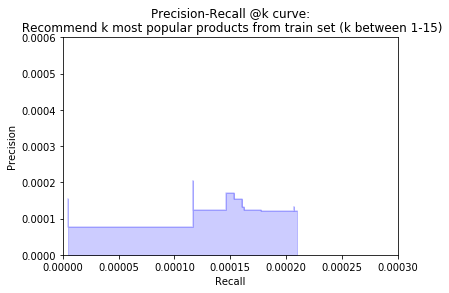

In [36]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

%matplotlib inline

#precision, recall, thresholds = precision_recall_curve(y_test, probas_pred = y_score)

plt.step(recall_scorefreq, precision_scorefreq, color='b', alpha=0.2,
         where='post')

plt.fill_between(recall_scorefreq, precision_scorefreq, step='post', alpha=0.2,
                 color='b')
plt.title('Precision-Recall @k curve:\n Recommend k most popular products from train set (k between 1-15)')
plt.ylim([0.0, 0.0006])
plt.xlim([0.0, 0.0003])
plt.xlabel('Recall')
plt.ylabel('Precision')

In [37]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

(0.0, 0.1)

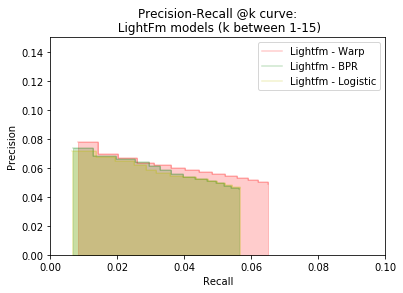

In [38]:
plt.step(recall_scores_warp, precision_scores_warp, color='r', alpha=0.2, where='post' , label='Lightfm - Warp')
plt.fill_between(recall_scores_warp, precision_scores_warp, step='post', alpha=0.2, color='r')

plt.step(recall_scores, precision_scores, color='g', alpha=0.2, where='post', label='Lightfm - BPR')
plt.fill_between(recall_scores, precision_scores, step='post', alpha=0.2, color='g')

plt.step(recall_scores_logistic, precision_scores_logistic, color='y', alpha=0.2, where='post', label='Lightfm - Logistic')
plt.fill_between(recall_scores_logistic, precision_scores_logistic, step='post', alpha=0.2, color='y')

plt.legend()
plt.title('Precision-Recall @k curve:\n LightFm models (k between 1-15)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 0.15])
plt.xlim([0.0, 0.1])

(0.0, 0.008)

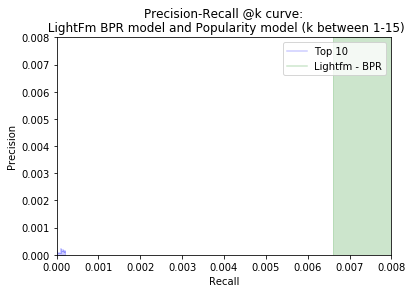

In [39]:
plt.step(recall_scorefreq, precision_scorefreq, color='b', alpha=0.2, where='post', label='Top 10')
plt.fill_between(recall_scorefreq, precision_scorefreq, step='post', alpha=0.2, color='b')
# Lightfm - BPR
plt.step(recall_scores, precision_scores, color='g', alpha=0.2, where='post', label='Lightfm - BPR')
plt.fill_between(recall_scores, precision_scores, step='post', alpha=0.2, color='g')

plt.legend()
plt.title('Precision-Recall @k curve:\n LightFm BPR model and Popularity model (k between 1-15)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 0.008])
plt.xlim([0.0, 0.008])

### Reciprocal Mean

In [40]:
recip_mean = []
for i,r in enumerate(processedtest):
    reciprocal = []
    #topk = list(traindf.product_id.value_counts()[:10])
    for n , x in enumerate(top10):
        if x in r:
            reciprocal.append(1/(n + 1))
        else:
            reciprocal.append(0)
    recip_mean.append(np.mean(reciprocal))
np.mean(recip_mean)

4.0066505279222216e-05

In [ ]:
recip = reciprocal_rank(model_bpr,test_interactions=test)
recip.mean()

0.16205502

In [23]:
recip = reciprocal_rank(model_warp,test_interactions=test)
recip.mean()

0.16763107

In [24]:
recip = reciprocal_rank(model_logistic,test_interactions=test)
recip.mean()

0.16415031